In [1]:
!pip install transformers

In [15]:
import random
import pandas as pd

# Function to randomly delete words from a sentence
def random_deletion(sentence, p=0.1):
    words = sentence.split()
    if len(words) == 1:
        return sentence

    # Keep words with probability 1 - p
    words = [word for word in words if random.uniform(0, 1) > p]
    return ' '.join(words) if words else sentence

# Function to randomly swap words in a sentence
def random_swap(sentence, n=2):
    words = sentence.split()
    if len(words) < 2:
        return sentence

    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Function to randomly add a word to the sentence
def random_insertion(sentence, n=1):
    words = sentence.split()
    if not words:
        return sentence
    for _ in range(n):
        word_to_add = random.choice(words)
        idx = random.randint(0, len(words))
        words.insert(idx, word_to_add)
    return ' '.join(words)

# Function to apply noise injection augmentation
def noise_injection(sentence, deletion_prob=0.1, num_swaps=2, num_insertions=1):
    if not sentence.strip():
        return sentence
    # Apply random deletion
    sentence = random_deletion(sentence, p=deletion_prob)
    # Apply random swap
    sentence = random_swap(sentence, n=num_swaps)
    # Apply random insertion
    sentence = random_insertion(sentence, n=num_insertions)
    return sentence

# Function to augment the entire dataset with noise injection
def augment_dataset_with_noise(data, num_augmentations=5, deletion_prob=0.1, num_swaps=2, num_insertions=1):
    augmented_texts = []

    for _, row in data.iterrows():
        sentence = row['corrected_tweet']
        label = row['class']
        augmented_texts.append({'corrected_tweet': sentence, 'class': label})

        # Generate augmented samples
        for _ in range(num_augmentations):
            augmented_sentence = noise_injection(
                sentence,
                deletion_prob=deletion_prob,
                num_swaps=num_swaps,
                num_insertions=num_insertions
            )
            augmented_texts.append({'corrected_tweet': augmented_sentence, 'class': label})

    return pd.DataFrame(augmented_texts)

# Load the dataset
dataset_path = '/content/labeled_data_cleaned_whole.csv'
data = pd.read_csv(dataset_path)

# Handle missing values
data['corrected_tweet'] = data['corrected_tweet'].fillna('')
data['corrected_tweet'] = data['corrected_tweet'].astype(str)

# Apply noise injection augmentation
augmented_data = augment_dataset_with_noise(data, num_augmentations=3, deletion_prob=0.1, num_swaps=2, num_insertions=1)

# Save the augmented dataset
augmented_dataset_path = '/content/augmented_dataset_noise_injection.csv'
augmented_data.to_csv(augmented_dataset_path, index=False)
print(f"Augmented dataset saved to {augmented_dataset_path}")


Augmented dataset saved to /content/augmented_dataset_noise_injection.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-5695c730cfd3>:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.382200,0.360460,0.898875,0.913729,0.898875,0.904645
2,0.300500,0.272675,0.925707,0.933567,0.925707,0.928365
3,0.179700,0.261782,0.944974,0.948414,0.944974,0.946221


Evaluation Results: {'eval_loss': 0.2617819905281067, 'eval_accuracy': 0.9449740253190094, 'eval_precision': 0.948414388535751, 'eval_recall': 0.9449740253190094, 'eval_f1': 0.9462211910890018, 'eval_runtime': 19.5297, 'eval_samples_per_second': 1015.224, 'eval_steps_per_second': 31.747, 'epoch': 3.0}
Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.69      0.81      0.74      1187
   Offensive       0.98      0.95      0.97     15371
     Neutral       0.91      0.95      0.93      3269

    accuracy                           0.94     19827
   macro avg       0.86      0.90      0.88     19827
weighted avg       0.95      0.94      0.95     19827



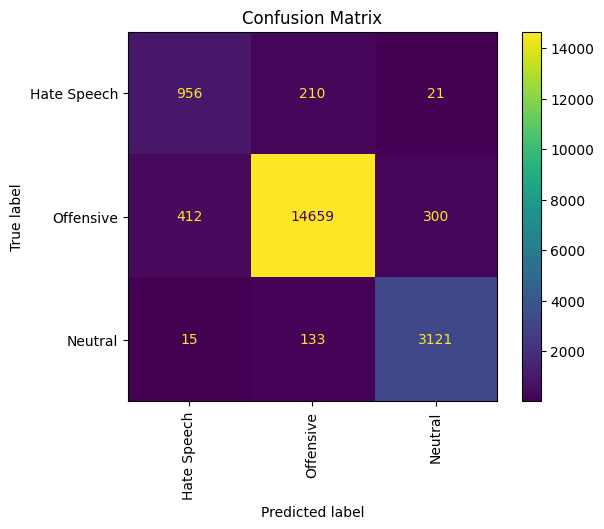

In [16]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

# Load Dataset
dataset_path = '/content/augmented_dataset_noise_injection.csv'  # Path to your augmented dataset
data = pd.read_csv(dataset_path)

# Handle missing values
data['corrected_tweet'] = data['corrected_tweet'].fillna('')
data['corrected_tweet'] = data['corrected_tweet'].astype(str)

# Separate texts and labels
texts = data['corrected_tweet'].values
labels = data['class'].values

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Load Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize Dataset with Reduced Sequence Length
def tokenize_texts(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)

# Convert Labels to Tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Define Custom Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create Datasets
train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Load Pretrained mBERT Model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=3  # Number of classes
)

# Unfreeze all layers
for param in model.bert.parameters():
    param.requires_grad = True

# Define class weights
class_weights = torch.tensor([5.0, 1.0, 2.0])

# Custom Trainer with Weighted Loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        class_weights_device = class_weights.to(logits.device)
        loss_fn = CrossEntropyLoss(weight=class_weights_device)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Training Arguments with Increased Epochs
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
)

# Trainer with Weighted Loss
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda pred: {
        'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        'precision': precision_recall_fscore_support(
            pred.label_ids, pred.predictions.argmax(-1), average='weighted'
        )[0],
        'recall': precision_recall_fscore_support(
            pred.label_ids, pred.predictions.argmax(-1), average='weighted'
        )[1],
        'f1': precision_recall_fscore_support(
            pred.label_ids, pred.predictions.argmax(-1), average='weighted'
        )[2],
    }
)

# Train the Model
trainer.train()

# Evaluate the Model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Save the Model
model.save_pretrained('./mbert_hate_speech_noise')
tokenizer.save_pretrained('./mbert_hate_speech_noise')

# Predict on Validation Set
val_outputs = trainer.predict(val_dataset)
preds = val_outputs.predictions.argmax(-1)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Classification Report:")
print(classification_report(val_labels, preds, target_names=['Hate Speech', 'Offensive', 'Neutral'], zero_division=0))

# Confusion Matrix
cm = confusion_matrix(val_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hate Speech', 'Offensive', 'Neutral'])
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
